## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
print(train_data.text_list[0])

['discharg', 'summari', 'unsign', 'admiss', 'date', 'report', 'statu', 'unsign', 'discharg', 'date', 'discharg', 'diagnosi', 'coronari', 'arteri', 'diseas', 'unstabl', 'angina', 'histori', 'present', 'ill', 'hoopl', 'old', 'woman', 'statu', 'post', 'doubl', 'coronari', 'arteri', 'bypass', 'graft', 'endarterectomi', 'fourteen', 'year', 'ago', 'develop', 'angina', 'six', 'month', 'ago', 'suffer', 'unstabl', 'angina', 'sever', 'day', 'coronari', 'catheter', 'result', 'show', 'sever', 'occlus', 'saphen', 'vein', 'graft', 'occlus', 'left', 'anterior', 'descend', 'echocardiogram', 'show', 'excel', 'left', 'ventricular', 'function', 'intraaort', 'balloon', 'pump', 'place', 'reliev', 'intract', 'angina', 'past', 'medic', 'histori', 'signific', 'chest', 'pain', 'short', 'breath', 'admit', 'talc', 'commun', 'medic', 'center', 'catheter', 'coronari', 'arteri', 'bypass', 'graft', 'coronari', 'endarterectomi', 'no', 'chest', 'pain', 'six', 'month', 'prior', 'admiss', 'time', 'inder', 'aspirin', 'si

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(train_data.text_list[200:400]+test_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0                could  0.799672
1   treatmentsprocedur  0.787904
2                brief  0.786802
3             endoscop  0.760261
4                 none  0.750893
5               though  0.733966
6             reproduc  0.725095
7               detail  0.723661
8                  yet  0.722726
9        arthrocentesi  0.705139
10           character  0.702516
11               resum  0.700770
12              applic  0.691492
13                felt  0.685543
14                oper  0.685237
15             brought  0.678591
16            descript  0.675590
17               taken  0.664112
18            procedur  0.662604
19               drive  0.655969


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0           hypothyroid  0.968535
1             hypertens  0.957984
2        hyperlipidemia  0.950290
3                  iddm  0.938910
4              arthriti  0.934763
5            neuropathi  0.927919
6           ketoacidosi  0.925397
7               mellitu  0.923300
8                disord  0.920897
9                mother  0.918781
10                adult  0.917473
11               seizur  0.916976
12        insulindepend  0.915050
13               reflux  0.914094
14          retinopathi  0.913135
15         postmenopaus  0.912625
16             nephriti  0.910504
17                  htn  0.908008
18            hyperchol  0.904921
19        gastroesophag  0.903759


In [9]:
print(most_similar(model, ["angina"]))

       angina       cos
0     unstabl  0.952042
1      recurr  0.916804
2       chief  0.914423
3      recent  0.908403
4     infarct  0.894256
5   complaint  0.892267
6     multipl  0.880401
7      syncop  0.878999
8         imi  0.876978
9     abscess  0.872435
10     system  0.860291
11      flare  0.859856
12      onset  0.858815
13    present  0.855521
14    impress  0.852492
15   myocardi  0.850271
16    exacerb  0.847443
17    nonqwav  0.845989
18       copd  0.842364
19     review  0.841238


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "hypercholesterolemia"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  7.089597010910511


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  8.317799778580666


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  6.698150155842304


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  8.638159633278846


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  8.477979705929755


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  6.893873583376408


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  7.685926644653081


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

1.6159846484661102

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.385
recall:  0.4350282485875706
F1-Score:  0.4084880636604774


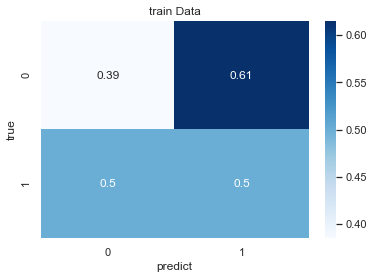

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.365
recall:  0.4101123595505618
F1-Score:  0.3862433862433862


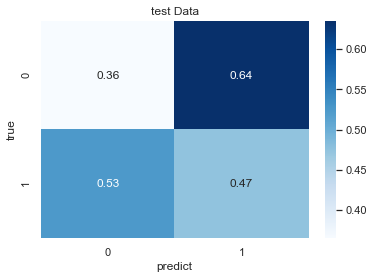

In [30]:
print_result(test_confusion_matrix, "test Data")